## Import neccessary modules
 - numpy: Basic array manipulation.
 - matplotlib: Plot for visualization.
 - [scikit-learn](https://scikit-learn.org): Basic machine learning modules.
 - [pymatgen](https://pymatgen.org): Basic materials data manipulation and analysis.
 - [monty](https://guide.materialsvirtuallab.org/monty): Materials data loading
 - [**maml**](https://github.com/materialsvirtuallab/maml): Machine learning interatomic potentials development

In [ ]:
# Command specified for nanohub user, enable lammps executable
import hublib.use
%use lammps-03Mar20

# Check the path of executable
from monty.os.path import which
which("lmp_serial")

In [1]:
# general imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from monty.serialization import loadfn
from maml.utils import pool_from, convert_docs

# local environment descriptors imports
from maml.describers import BispectrumCoefficients
from sklearn.decomposition import PCA

# machine learning interatomic potentials imports
from maml.base import SKLModel
from maml.apps.pes import SNAPotential
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

# materials properties prediction imports
from pymatgen import Structure, Lattice
from maml.apps.pes import LatticeConstant, ElasticConstant, NudgedElasticBand, DefectFormation

# disable logging information
import logging
logging.disable(logging.CRITICAL)

### Load DFT-computed data

Load the Mo DFT-computed data, there are six categories of data (AIMD-NVT, AIMD-NPT, Elastic, Surface, Vacancy-AIMD, Grain-Boundary, the detailed descriptions of the data are provided [here](https://journals.aps.org/prmaterials/abstract/10.1103/PhysRevMaterials.1.043603)).

In [2]:
Mo_aimd_nvt_data = loadfn('./data/Mo/AIMD_NVT.json')
Mo_aimd_npt_data = loadfn('./data/Mo/AIMD_NPT.json')
Mo_elastic_data = loadfn('./data/Mo/Elastic.json')
Mo_surface_data = loadfn('./data/Mo/Surface.json')
Mo_vacancy_data = loadfn('./data/Mo/Vacancy.json')
Mo_gb_data = loadfn('./data/Mo/GB.json')

print(' # of Mo AIMD NVT data: {}\n'.format(len(Mo_aimd_nvt_data)), 
      '# of Mo AIMD NPT data: {}\n'.format(len(Mo_aimd_npt_data)), 
      '# of Mo Elastic data: {}\n'.format(len(Mo_elastic_data)), 
      '# of Mo Surface data: {}\n'.format(len(Mo_surface_data)),
      '# of Mo Vacancy data: {}\n'.format(len(Mo_vacancy_data)),
      '# of Mo GB data: {}'.format(len(Mo_gb_data)))

 # of Mo AIMD NVT data: 120
 # of Mo AIMD NPT data: 49
 # of Mo Elastic data: 67
 # of Mo Surface data: 11
 # of Mo Vacancy data: 24
 # of Mo GB data: 13


Load the Ni-Mo DFT-computed data, there are also six categories of data (Mo with Ni dopant, Ni with Mo dopant, Ni3Mo AIMD, Ni4Mo AIMD, Ni3Mo Elastic, Ni4Mo Elastic, the detailed descriptions of the data are provided [here](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.98.094104)). There a lot more data required for binary system than pure elemental system.

In [3]:
Mo_dopedwith_Ni_data = loadfn('./data/Ni-Mo/Mo_dopedwith_Ni.json')
Ni_dopedwith_Mo_data = loadfn('./data/Ni-Mo/Ni_dopedwith_Mo.json')
Ni3Mo_aimd_data = loadfn('./data/Ni-Mo/Ni3Mo_AIMD.json')
Ni4Mo_aimd_data = loadfn('./data/Ni-Mo/Ni4Mo_AIMD.json')
Ni3Mo_elastic_data = loadfn('./data/Ni-Mo/Ni3Mo_Elastic.json')
Ni4Mo_elastic_data = loadfn('./data/Ni-Mo/Ni4Mo_Elastic.json')

print(' # of Mo doped with Ni data: {}\n'.format(len(Mo_dopedwith_Ni_data)), 
      '# of Ni doped with Mo data: {}\n'.format(len(Ni_dopedwith_Mo_data)), 
      '# of Ni3Mo AIMD data: {}\n'.format(len(Ni3Mo_aimd_data)), 
      '# of Ni4Mo AIMD data: {}\n'.format(len(Ni4Mo_aimd_data)),
      '# of Ni3Mo Elastic data: {}\n'.format(len(Ni3Mo_elastic_data)),
      '# of Ni4Mo Elastic data: {}'.format(len(Ni4Mo_elastic_data)))

 # of Mo doped with Ni data: 918
 # of Ni doped with Mo data: 1668
 # of Ni3Mo AIMD data: 200
 # of Ni4Mo AIMD data: 200
 # of Ni3Mo Elastic data: 121
 # of Ni4Mo Elastic data: 121


### Bispectrum coefficients features

Transform each atom in structures to one array of feature, set **pot_fit = False**

Hyperparameters:
 - cutoff: The cutoff radius to determine the maximum range of interatomic interactions.
 - twojmax: 2 * The number limits the indices $j_{1}$, $j_{2}$ and $j$ in the definition of bispectrum coefficients: $B_{j_{1}, j_{2}, j} = \sum_{m_{1}, m_{1}^{\prime}=-j_{1}}^{j_{1}}
                       \sum_{m_{2}, m_{2}^{\prime}=-j_{2}}^{j_{2}}
                        \sum_{m, m^{\prime}=-j}^{j} (u_{m, m^{\prime}}^{j})^{\ast}
         \times H\substack{j m m\prime \\ j_{1} m_{1} m_{1}^{\prime} \\ j_{2} m_{2} m_{2}^{\prime}} u_{m_{1}, m_{1}^{\prime}}^{j_{1}} u_{m_{2}, m_{2}^{\prime}}^{j_{2}}$. It determines the dimensions of bispectrum coefficients features. This value is typically 6 or 8.
 - element_profile: The factor "r" to scale the cutoff and weight "w" of each element.
 - quadratic: Whether to use [quadratic](https://aip.scitation.org/doi/full/10.1063/1.5017641) SNAP formulism. Currently set to False as we focus on the [linear](https://www.sciencedirect.com/science/article/pii/S0021999114008353) SNAP for now.
 - pot_fit: If set True, output 1 feature per structure + 1 feature per atomic force component (**1+3n features for n-atom structure**).
 If set False, output feature per atom (**n features for n-atom structure**)
 - include_stress: Whether to include stress component for training, cuurently set to False as we will only use energy and forces as targets.

In [9]:
# Let's try a small set of Mo data (AIMD NPT)

element_profile = {'Mo': {'r': 0.5, 'w': 1.0}}
per_atom_describer = BispectrumCoefficients(cutoff=4.6, twojmax=6, 
                                                 element_profile=element_profile, 
                                                 quadratic=False, 
                                                 pot_fit=False, 
                                                 include_stress=False)

Mo_aimd_npt_structures = [d['structure'] for d in Mo_aimd_npt_data]
per_atom_features = per_atom_describer.transform(Mo_aimd_npt_structures)

print("Total # of atoms in Mo AIMD NPT: 54 * 49 = {}\n".format(sum([len(struct) for struct in Mo_aimd_npt_structures])), 
      "     # of features generated: {} (one feature per atom)\n".format(per_atom_features.shape[0]),
      "     # of dimensions: {} (for twojmax = 6)".format(per_atom_features.shape[1]))

per_atom_features

Total # of atoms in Mo AIMD NPT: 54 * 49 = 2646
      # of features generated: 2646 (one feature per atom)
      # of dimensions: 30 (for twojmax = 6)


0-0-0     1-0-1     1-1-2     2-0-2     2-1-3    2-2-2  \
input_index                                                                
0           0   75.2940  1.203270  0.208015   9.52031 -1.215790  1.56909   
            1   57.2507  2.157770  0.063651  14.13190 -1.601050  2.05782   
            2   60.0362  0.412955 -0.065808  11.15120  0.005526  1.21908   
            3   54.4838  0.808519 -0.074506  13.22440 -0.482870  1.32215   
            4   36.4083  1.669280 -0.086670  18.85420 -0.746443  4.38312   
...                 ...       ...       ...       ...       ...      ...   
48          49  60.7944  1.843570  0.381687  14.00640 -2.462870  3.42033   
            50  51.8788  1.590430  0.084819  14.87630 -1.873320  3.24910   
            51  47.9306  0.968913  0.473004  17.27090 -2.104800  4.54849   
            52  47.9638  0.580570 -0.119198  11.22450 -0.321299  1.02643   
            53  42.5152  0.739316 -0.023245  12.65060 -0.753006  2.74154   

                  2-2-4    3-0-3     3-1-4    3-2-3  ...    5-0-5     5-1-6  \
input_index                                          ...                      
0           0   2.49414  43.8975 -1.836580  6.58286  ...  35.9151 -1.268370   
            1   3.85471  32.3748 -0.172077  7.68918  ...  37.7378 -0.889240   
            2   2.52985  31.5629  0.006021  3.25140  ...  49.4575 -0.147099   
            3   2.75047  30.3902 -0.485312  6.09683  ...  36.7352 -0.209425   
            4   7.93946  18.3444 -0.005479  5.78473  ...  34.8445 -0.483801   
...                 ...      ...       ...      ...  ...      ...       ...   
48          49  3.21464  36.1154 -1.241750  8.56881  ...  37.3704 -2.962000   
            50  4.05806  30.6860 -0.409098  7.79721  ...  40.5566 -1.201340   
            51  5.19646  30.9329 -1.596150  8.36923  ...  31.7020 -2.005210   
            52  3.25513  28.2930 -0.131562  6.49821  ...  32.1957  0.029395   
            53  4.03156  26.0994 -0.605423  6.92782  ...  31.8600 -0.289558   

                  5-2-5     5-3-6    5-4-5    5-5-6    6-0-6     6-2-6  \
input_index                                                              
0           0   1.46323  10.81430  2.57809  5.95661  63.2703   6.11618   
            1   4.21522  10.94180  6.17744  6.24957  48.8460   6.54850   
            2   2.60601   8.69569  9.56190  7.29800  40.7988   3.44216   
            3   2.81557   9.85795  6.41540  5.88736  48.6594   5.95651   
            4   9.45586   7.42009  7.77407  8.30356  31.5125   7.88372   
...                 ...       ...      ...      ...      ...       ...   
48          49  6.83188  12.38580  4.38370  9.13123  49.5601   7.95001   
            50  7.11509  11.21240  6.86837  8.99976  43.9404   6.78860   
            51  6.96420  10.37980  4.57518  8.52250  45.6320  10.10480   
            52  2.31925  10.52270  4.97734  4.62686  49.1665   6.14407   
            53  2.78214  10.95440  5.02473  5.57721  46.9986   8.06957   

                   6-4-6     6-6-6  
input_index                         
0           0   10.86920  11.74600  
            1    6.33256  11.21050  
            2    7.21221   5.32912  
            3    8.68538   9.24680  
            4    6.47652   5.22694  
...                  ...       ...  
48          49   7.16098  10.27780  
            50   6.86834   7.67999  
            51   7.65267   8.37457  
            52   8.43600  11.97750  
            53   8.19857  14.13250  

[2646 rows x 30 columns]

Transform each structure to one feature for structure and one feature for each atomic force component, set **pot_fit = True**

The dimension of features is 31 instead of 30. There is one extra intercept term at the beginning of the feature. This term is disminished for forces as the intercept disappears in the derivative of the energy.

In [14]:
element_profile = {'Mo': {'r': 0.5, 'w': 1.0}}
per_force_describer = BispectrumCoefficients(cutoff=4.6, twojmax=6, 
                                                 element_profile=element_profile, 
                                                 quadratic=False, 
                                                 pot_fit=True, 
                                                 include_stress=False)

Mo_aimd_npt_structures = [d['structure'] for d in Mo_aimd_npt_data]
per_force_features = per_force_describer.transform(Mo_aimd_npt_structures)

print("Total # of features expected in Mo AIMD NPT: (1 + 54 * 3) * 49 = {}\n".format(sum([(1 + 3 * len(struct)) for struct in Mo_aimd_npt_structures])), 
      "     # of features generated: {} (1+3n features for n-atom structure)\n".format(per_force_features.shape[0]),
      "     # of dimensions: {}".format(per_force_features.shape[1]))

per_force_features

Total # of features expected in Mo AIMD NPT: (1 + 54 * 3) * 49 = 7987
      # of features generated: 7987 (1+3n features for n-atom structure)
      # of dimensions: 31


Mo                                                       \
                    n      0-0-0      1-0-1     1-1-2      2-0-2     2-1-3   
input_index                                                                  
0           0     1.0  62.518704   1.677475 -0.052646  11.728518 -0.671172   
            0_x   0.0 -38.208700  -7.843550  0.799808  -0.989909 -0.602128   
            0_y   0.0   1.119810  -2.809430  0.244669   8.687370 -0.161566   
            0_z   0.0  32.938500   7.805930  0.628442  -6.601300 -3.240370   
            1_x   0.0 -32.062300 -11.634100  1.160060  12.467400 -1.498280   
...               ...        ...        ...       ...        ...       ...   
48          52_y  0.0  10.965500   0.638320 -0.665185  -3.450260  1.899080   
            52_z  0.0   3.002040  -0.547607  0.492503   6.079170  0.328471   
            53_x  0.0 -14.887200  -3.657080  1.218350  13.969300 -1.811120   
            53_y  0.0  -2.193870  -1.516480 -0.047089  -6.240230  0.463664   
            53_z  0.0  -0.627488  -1.156000  0.970763   5.198870 -1.596760   

                                                           ...             \
                     2-2-2     2-2-4      3-0-3     3-1-4  ...      5-0-5   
input_index                                                ...              
0           0     1.454795  2.998469  35.080481  0.138436  ...  39.230063   
            0_x  -0.848962  5.611390  -4.848590 -3.442950  ...  17.825000   
            0_y   4.931130 -1.835140   6.730600 -1.120860  ...  21.302800   
            0_z   0.021938 -0.307319  19.549000 -0.317790  ... -17.793400   
            1_x   4.908080  1.019410   0.803641 -9.054610  ...   9.517620   
...                    ...       ...        ...       ...  ...        ...   
48          52_y -2.492180  0.948182  -2.708610 -0.071946  ...   3.904780   
            52_z  0.796584 -2.236820   0.908281 -0.005605  ... -12.064300   
            53_x  6.073770  2.590480 -17.227800 -3.435970  ...  15.867000   
            53_y -3.132720 -2.273250   8.722210 -2.264780  ...  -2.952200   
            53_z  2.133190 -1.268670   2.559210 -2.956570  ...  -0.278082   

                                                                      \
                     5-1-6      5-2-5     5-3-6      5-4-5     5-5-6   
input_index                                                            
0           0    -0.012918   3.374805  9.948534   6.475104  6.606595   
            0_x  -2.301430  -3.560320 -2.950230   3.205370  0.545968   
            0_y  -1.657180   8.085480  5.790270   3.610970  9.233560   
            0_z  -0.368478  -6.508310  2.568060 -11.921800 -2.220830   
            1_x  -8.216340  11.820900  5.950290  -1.263160  8.121500   
...                    ...        ...       ...        ...       ...   
48          52_y  3.216880  -2.613550 -6.091360   1.481280 -0.758690   
            52_z -1.076360   6.522480 -0.989705  -2.829090  4.421450   
            53_x -2.990200  10.349200  3.971940   5.174510  8.296870   
            53_y -0.425743  -2.213110  5.185710  -1.654070 -0.836939   
            53_z -1.946390   1.083160  7.714750  -1.526110  0.527062   

                                                              
                      6-0-6      6-2-6      6-4-6      6-6-6  
input_index                                                   
0           0     54.370637   5.302849   9.134025   9.369957  
            0_x  -59.164800   3.873000 -17.899500 -10.592000  
            0_y   -3.108420   2.687700  -4.900980   5.916770  
            0_z   47.382600   6.883140   6.256090  15.809300  
            1_x    5.647190  10.586900  -2.121930  15.789900  
...                     ...        ...        ...        ...  
48          52_y   1.733620  -6.294780  -0.303610  -5.412190  
            52_z  22.909000   5.016640   0.867715  10.930500  
            53_x  -9.311910   7.815200  -3.992570   5.753930  
            53_y   1.255900   5.561130  -4.886720   4.744630  
            53_z   

A reasonable set of structures for potential fitting tends to provide a good coverage of the feature space. However, 
distribution of features with 30 dimensions is impossible to visualize. We need to reduce the dimensions while maintaining most of the information. [Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) is one of the most important dimension reduction algorithms. PCA keeps the first two principal components which maximize the variances (information) between the features.

### Usage:
    pca = PCA(n_components = 2)
    pca.fit(features)
    reduced_features = pca.transform(features)

In [15]:
# Obtain structures from each categories
Mo_aimd_nvt_structures = [d['structure'] for d in Mo_aimd_nvt_data]
Mo_aimd_npt_structures = [d['structure'] for d in Mo_aimd_npt_data]
Mo_elastic_structures = [d['structure'] for d in Mo_elastic_data]
Mo_surface_structures = [d['structure'] for d in Mo_surface_data]
Mo_vacancy_structures = [d['structure'] for d in Mo_vacancy_data]
Mo_gb_structures = [d['structure'] for d in Mo_gb_data]

# Obtain the features from each categories
Mo_aimd_nvt_features = per_atom_describer.transform(Mo_aimd_nvt_structures)
Mo_aimd_npt_features = per_atom_describer.transform(Mo_aimd_npt_structures)
Mo_elastic_features = per_atom_describer.transform(Mo_elastic_structures)
Mo_surface_features = per_atom_describer.transform(Mo_surface_structures)
Mo_vacancy_features = per_atom_describer.transform(Mo_vacancy_structures)
Mo_gb_features = per_atom_describer.transform(Mo_gb_structures)

# Add up features
total_Mo_features = np.concatenate((Mo_aimd_nvt_features, Mo_aimd_npt_features, Mo_elastic_features, 
                                    Mo_surface_features, Mo_vacancy_features, Mo_gb_features), axis=0)

# Fit the PCA
pca = PCA(n_components=2)
pca.fit(total_Mo_features)

Mo_aimd_nvt_pcs = pca.transform(Mo_aimd_nvt_features)
Mo_aimd_nvt_pc1 = Mo_aimd_nvt_pcs[:, 0]
Mo_aimd_nvt_pc2 = Mo_aimd_nvt_pcs[:, 1]

Mo_aimd_npt_pcs = pca.transform(Mo_aimd_npt_features)
Mo_aimd_npt_pc1 = Mo_aimd_npt_pcs[:, 0]
Mo_aimd_npt_pc2 = Mo_aimd_npt_pcs[:, 1]

Mo_gb_pcs = pca.transform(Mo_gb_features)
Mo_gb_pc1 = Mo_gb_pcs[:, 0]
Mo_gb_pc2 = Mo_gb_pcs[:, 1]

Mo_elastic_pcs = pca.transform(Mo_elastic_features)
Mo_elastic_pc1 = Mo_elastic_pcs[:, 0]
Mo_elastic_pc2 = Mo_elastic_pcs[:, 1]

Mo_surface_pcs = pca.transform(Mo_surface_features)
Mo_surface_pc1 = Mo_surface_pcs[:, 0]
Mo_surface_pc2 = Mo_surface_pcs[:, 1]

Mo_vacancy_pcs = pca.transform(Mo_vacancy_features)
Mo_vacancy_pc1 = Mo_vacancy_pcs[:, 0]
Mo_vacancy_pc2 = Mo_vacancy_pcs[:, 1]

Visualization of PCA of different catergories, x axis is the first principal compnent (PC1), y axis is the second principal component (PC2). This figure yields almost the same results in Fig 2(a) of the [work](https://journals.aps.org/prmaterials/pdf/10.1103/PhysRevMaterials.1.043603).

(-50.0, 170.0)

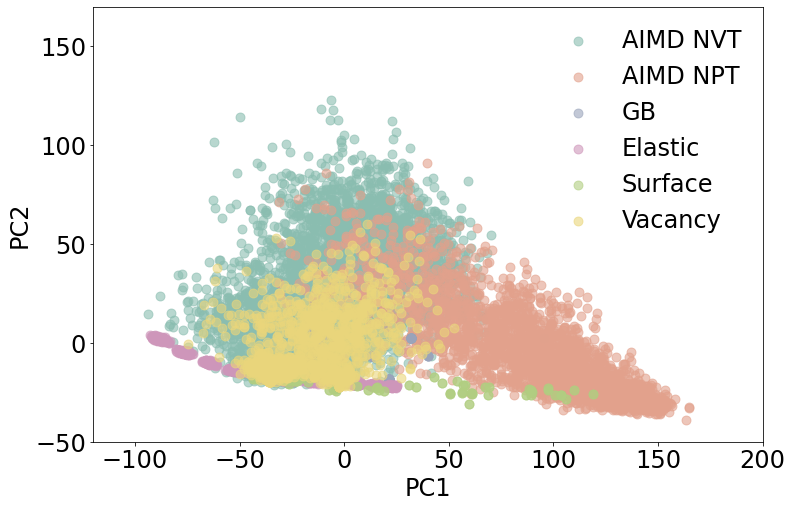

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(Mo_aimd_nvt_pc1, Mo_aimd_nvt_pc2, c='#8ABDB0', alpha=0.6, s=80, label='AIMD NVT')
ax.scatter(Mo_aimd_npt_pc1, Mo_aimd_npt_pc2, c='#E2A18C', alpha=0.6, s=80, label='AIMD NPT')
ax.scatter(Mo_gb_pc1, Mo_gb_pc2, c='#9AA4BB', alpha=0.6, s=80, label='GB')
ax.scatter(Mo_elastic_pc1, Mo_elastic_pc2, c='#CE96BA', alpha=0.6, s=80, label='Elastic')
ax.scatter(Mo_surface_pc1, Mo_surface_pc2, c='#B1CE81', alpha=0.6, s=80, label='Surface')
ax.scatter(Mo_vacancy_pc1, Mo_vacancy_pc2, c='#EAD67B', alpha=0.6, s=80, label='Vacancy')

from matplotlib import ticker

ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))

plt.legend(fontsize=24, frameon=False)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('PC1', fontsize=24)
plt.ylabel('PC2', fontsize=24)
plt.xlim(-120, 200)
plt.ylim(-50, 170)

### Data structure of the training dataset

Split the dataset into three lists:
 - list of structure objects [Structure object for each structure]
 - list of energies [total_energy for each structure], 
 - list of forces [n x 3 forces array for each n-atom structure], n can be different for different structures.

In [18]:
Mo_data = Mo_aimd_nvt_data + Mo_aimd_npt_data + Mo_elastic_data + Mo_surface_data + Mo_vacancy_data + Mo_gb_data
Mo_train_structures = [d['structure'] for d in Mo_data]
Mo_train_energies = [d['outputs']['energy'] for d in Mo_data]
Mo_train_forces = [d['outputs']['forces'] for d in Mo_data]

print(" # of structures in Mo data: {}\n".format(len(Mo_train_structures)),
      "# of energies in Mo data: {}\n".format(len(Mo_train_energies)),
      "# of forces in Mo data: {}\n".format(len(Mo_train_forces)),
      "first item in energies: {}\n".format(Mo_train_energies[0]),
      "first item in forces: (n x 3 array)\n", np.array(Mo_train_forces[0]))

 # of structures in Mo data: 284
 # of energies in Mo data: 284
 # of forces in Mo data: 284
 first item in energies: -581.6806102
 first item in forces: (n x 3 array)
 [[ 0.65748785 -0.28864427 -1.84893675]
 [ 2.09722726 -0.91296716 -0.29415063]
 [ 0.65563088 -0.14080055 -0.18287363]
 [ 1.26930592  0.01934864 -0.37475849]
 [ 0.13167307 -0.51922075  0.00858145]
 [ 0.09849057  0.32694928 -1.87384252]
 [ 0.84183545 -1.07741626  0.56028755]
 [ 1.12196976  2.03699782  0.52075135]
 [ 0.45314683 -0.58908718 -1.53356622]
 [ 1.26218024 -0.07754766 -1.90818053]
 [ 0.35654818 -0.12618272 -0.184839  ]
 [ 0.31799464 -0.83850645  0.23754962]
 [ 0.65487466 -0.5699247  -1.01376075]
 [-0.0230253   0.26458353 -1.20195509]
 [ 1.21681973  0.59359657 -0.17623466]
 [ 0.11935181  0.00620064 -0.6674934 ]
 [ 0.1303862  -0.85521977 -0.0896365 ]
 [ 1.2772755  -0.81193946 -0.04174854]
 [ 0.37568111  0.73119649 -2.27935764]
 [-0.08718597 -0.67883705  0.27561103]
 [ 0.83587697 -0.74660824 -0.65532741]
 [-0.1081617

Let's use the features with pot_fit = False, i.e., **1+3n features for n-atom structure**

In [19]:
Mo_features = per_force_describer.transform(Mo_train_structures)
print("# of features generated: {}".format(Mo_features.shape[0]))
Mo_features

# of features generated: 47084


Mo                                                       \
                    n       0-0-0     1-0-1     1-1-2      2-0-2     2-1-3   
input_index                                                                  
0           0     1.0  143.088278  3.077364  0.360052   3.559427 -1.850642   
            0_x   0.0   -4.643240 -0.517042 -0.136732   5.374000 -0.063576   
            0_y   0.0   -0.025625  0.340429 -0.417003  -3.225250  0.518184   
            0_z   0.0    4.979300  1.347350  0.554854 -13.299000 -0.278200   
            1_x   0.0   -5.567960 -0.774104 -0.917239  12.071900  0.719025   
...               ...         ...       ...       ...        ...       ...   
283         78_y  0.0    6.532540 -0.015935  0.218968   1.953490 -0.187456   
            78_z  0.0    0.970182 -3.548260 -0.294022   0.299409  1.132980   
            79_x  0.0  -16.685000 -3.023330 -0.144236  -2.601670  1.630410   
            79_y  0.0   16.993500  4.506430 -0.398595  -2.435250  0.395611   
            79_z  0.0   28.400100  3.627780 -1.615390 -16.695000  5.165900   

                                                           ...              \
                     2-2-2     2-2-4      3-0-3     3-1-4  ...       5-0-5   
input_index                                                ...               
0           0     0.301597  0.798475  77.732793 -4.185007  ...   16.417515   
            0_x   0.870289 -0.597283  -7.300820  1.310150  ...   86.542400   
            0_y  -0.549597 -0.354791  11.148700  1.247110  ...  -38.446600   
            0_z  -0.637996  0.687815  33.042800 -3.206670  ... -135.992000   
            1_x   0.706999  0.137395 -36.637100  4.222750  ...  142.957000   
...                    ...       ...        ...       ...  ...         ...   
283         78_y  0.264565  0.242290  -3.946470 -0.150803  ...   -3.306010   
            78_z  0.999821  0.524519   5.708710 -1.198400  ...   22.797900   
            79_x  0.799335 -2.242140  10.659800  1.283820  ...  -25.232100   
            79_y -1.278060  1.464520 -10.169100  0.470072  ...  -24.686500   
            79_z -3.266030 -0.781021  20.709600  3.129510  ...  -39.275500   

                                                                         \
                      5-1-6      5-2-5      5-3-6      5-4-5      5-5-6   
input_index                                                               
0           0     -2.782924   0.873982  10.364813   1.961845   3.355029   
            0_x    2.584390   1.540650  14.239100  11.185800  11.880500   
            0_y   -0.414475  -0.569659  -5.773100  -3.482540  -2.225330   
            0_z   -6.420060  -1.292480 -18.899600 -16.884300 -11.571800   
            1_x    8.205350   0.391184  15.357700  17.841600   9.670230   
...                     ...        ...        ...        ...        ...   
283         78_y  -0.391013   0.452260  -0.517794   0.248122  -0.343553   
            78_z   0.994848   2.627280   1.288940   4.339670   5.893460   
            79_x  -1.077540   2.308630  -4.146210  -5.791160   0.990468   
            79_y   4.989650  -6.015490  -8.067700  -1.920830 -13.467400   
            79_z  13.150300 -12.032300  -4.230120  -7.949710 -10.241000   

                                                              
                       6-0-6     6-2-6      6-4-6      6-6-6  
input_index                                                   
0           0     137.559426  1.996578  14.370613  17.698969  
            0_x   -40.391400 -1.627660 -17.556300   8.339260  
            0_y    18.343100 -0.146907   6.593420  -5.315590  
            0_z    77.138900  1.144200  12.540100  -2.927060  
            1_x  -102.535000 -2.455780  -9.849150 -13.020300  
...                      ...       ...        ...        ...  
283         78_y   15.381700  1.185230   0.057683   7.409560  
            78_z   16.515800 -1.472660  -1.820600   4.062130  
            79_x   -1.005480 -4.342240   0.921343   0.272730  
            79_y   17.2085

In [21]:
Mo_train_pool = pool_from(Mo_train_structures, Mo_train_energies, Mo_train_forces)
_, Mo_df = convert_docs(Mo_train_pool)
print("# of targets: ", len(Mo_df))
Mo_df

# of targets:  47084


,y_orig,n,dtype
0,-581.680610,54.0,energy
1,0.657488,1.0,force
2,-0.288644,1.0,force
3,-1.848937,1.0,force
4,2.097227,1.0,force
...,...,...,...
47079,0.000305,1.0,force
47080,0.005354,1.0,force
47081,-0.012626,1.0,force
47082,0.001318,1.0,force


Create targets per atom (energy per atom = total_energies / num_atoms, force components per atom = $f_{x}$, $f_{y}$, $f_{z}$.

Use sklearn LinearRegression model to fit the features and targets, both simple linear model and weighted linear model are obtained

In [22]:
##### Simple Linear regression
y = Mo_df['y_orig'] / Mo_df['n']
x = Mo_features

simple_model = LinearRegression()
simple_model.fit(x, y)

##### Increase the weights of energies since the number of forces are overwhelming
weights = np.ones(len(Mo_df['dtype']), )
weights[Mo_df['dtype'] == 'energy'] = 10000
weights[Mo_df['dtype'] == 'force'] = 1

weighted_model = LinearRegression()
weighted_model.fit(x, y, sample_weight=weights)

print("# of parameters in simple linear model: {}\n".format(len(simple_model.coef_)), 
      "parameters in simple linear model: \n", simple_model.coef_, "\n")
print("# of parameters in weighted linear model: {}\n".format(len(weighted_model.coef_)), 
      "parameters in weighted linear model: \n", weighted_model.coef_)

# of parameters in simple linear model: 31
 parameters in simple linear model: 
 [-1.51954111e+01  9.86645803e-03  1.55776696e-02  4.72156860e-01
  3.63568492e-02  5.13039502e-01 -8.08130623e-03  2.70028222e-01
  3.64849583e-02  2.22644721e-01  1.89399005e-01  7.37284662e-02
  8.19751321e-03 -7.41907840e-03  4.06533549e-02  5.99160405e-02
 -2.09169261e-02  7.82197633e-02 -5.03816284e-02 -2.31968695e-02
 -4.18341907e-02  1.60836998e-02  3.73633839e-02  6.64078480e-02
 -2.27511772e-02 -2.52610086e-02 -1.15730663e-02 -1.19419479e-03
  3.89925288e-02 -7.49394309e-03  7.55379930e-03] 

# of parameters in weighted linear model: 31
 parameters in weighted linear model: 
 [-1.42506688e+01  1.30602375e-02  4.39782253e-02  4.94011770e-01
  2.25244025e-02  7.40943817e-01  6.08093752e-02  2.52090527e-01
  2.43301121e-02  2.22854217e-01  1.92071337e-01  9.03713430e-02
 -9.10274358e-03 -8.36338527e-03  3.20990237e-02  4.72062860e-02
 -1.63874737e-02  7.71772861e-02 -4.97037774e-02 -2.65589328e-02
 -

Predict the energy and forces using fitted machine learning models, get the errors of energies and forces

In [23]:
energy_indices = np.argwhere(np.array(Mo_df["dtype"]) == "energy").ravel()
forces_indices = np.argwhere(np.array(Mo_df["dtype"]) == "force").ravel()

simple_predict_y = simple_model.predict(x)
weighted_predict_y = weighted_model.predict(x)

original_energy = y[energy_indices]
original_forces = y[forces_indices]
simple_predict_energy = simple_predict_y[energy_indices]
simple_predict_forces = simple_predict_y[forces_indices]
weighted_predict_energy = weighted_predict_y[energy_indices]
weighted_predict_forces = weighted_predict_y[forces_indices]

print(" Simple model energy MAE: {:.3f} meV/atom\n".format(mean_absolute_error(original_energy, simple_predict_energy) * 1000),
      "Simple model forces MAE: {:.3f} eV/Å\n".format(mean_absolute_error(original_forces, simple_predict_forces)),
      "Weighted model energy MAE: {:.3f} meV/atom\n".format(mean_absolute_error(original_energy, weighted_predict_energy) * 1000),
      "Weighted model forces MAE: {:.3f} eV/Å\n".format(mean_absolute_error(original_forces, weighted_predict_forces)),)

 Simple model energy MAE: 102.796 meV/atom
 Simple model forces MAE: 0.315 eV/Å
 Weighted model energy MAE: 15.874 meV/atom
 Weighted model forces MAE: 0.313 eV/Å

